In [1]:
%config IPCompleter.greedy = True

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np

import pickle
import gzip
import h5py
import scipy

import sklearn
import sklearn.datasets

from PIL import Image
from scipy import ndimage

import matplotlib.pyplot as plt
%matplotlib inline

### 1. Load MNIST Data
***

In [4]:
def load_data():
    f = gzip.open('mnist.pkl.gz', 'rb')
    f.seek(0)
    
    training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    
    f.close()

    return (training_data, validation_data, test_data)

Let's see how the data looks:

In [5]:
training_data, validation_data, test_data = load_data()

In [6]:
training_data

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([5, 0, 4, ..., 8, 4, 8], dtype=int64))

Here we see that each dataset is represented by a tuple comprising of 2 arrays :

  - first element represents pixelated images where each element has a length of 784 (28 X 28)
  - second element represents true labels of individual images

In [7]:
# shape of data
print(training_data[0].shape)
print(training_data[1].shape)

(50000, 784)
(50000,)


In [8]:
print("Feature dataset : {}".format(training_data[0]))
print("Target dataset : {}\n".format(training_data[1]))

print("Number of examples in the training dataset : {}".format(len(training_data[0])))
print("Number of points in a single input : {}\n".format(len(training_data[0][1])))

print("Number of elements in the target dataset : {}".format(len(training_data[1])))

Feature dataset : [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Target dataset : [5 0 4 ... 8 4 8]

Number of examples in the training dataset : 50000
Number of points in a single input : 784

Number of elements in the target dataset : 50000


> -  *Number of images present in the training dataset : 50,000*
-  *Each image is represented by 784 data points representing a 28 X 28 image*
-  *Each element in target dataset represents expected image label*

### 2. Data Preparation
***

Convert output image label into one-hot encoded column vectors

In [9]:
def one_hot(j):
    # get the number of elements in the input array
    n = j.shape[0]

    # creates a 10 X n array 
    # each row represents a digit i.e. 10 rows (0 - 9)
    # each column represents an input
    new_array = np.zeros((10, n))

    index = 0

    for res in j:
        new_array[res][index] = 1.0
        index = index + 1
    
    return new_array

Convert datasets into desired shapes and the ground truth labels to one_hot matrix

In [10]:
def data_wrapper(tr_d, va_d, te_d):

    # transpose input matrix so that each input is represented by a column vector
    training_inputs = np.array(tr_d[0][:]).T
    validation_inputs = np.array(va_d[0][:]).T
    test_inputs = np.array(te_d[0][:]).T

    # generate one-hot encoded matrix for output labels
    training_results = np.array(tr_d[1][:])
    train_set_y = one_hot(training_results)

    validation_results = np.array(va_d[1][:])
    validation_set_y = one_hot(validation_results)

    test_results = np.array(te_d[1][:])
    test_set_y = one_hot(test_results)

    return (training_inputs, train_set_y, test_inputs, test_set_y)

In [11]:
train_set_x, train_set_y, test_set_x, test_set_y = data_wrapper(
    training_data, validation_data, test_data)

In [12]:
print ("train_set_x shape: " + str(train_set_x.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x shape: (784, 50000)
train_set_y shape: (10, 50000)
test_set_x shape: (784, 10000)
test_set_y shape: (10, 10000)


We can see that the data_wrapper has converted the training and validation data into numpy array of desired shapes. Let's convert the actual labels into a dataframe to see if the one hot conversions are correct.

In [13]:
y = pd.DataFrame(train_set_y)

In [14]:
print("The target dataset is:" + str(training_data[1]))
print("The one hot encoding dataset is:")
y

The target dataset is:[5 0 4 ... 8 4 8]
The one hot encoding dataset is:


,0,1,2,3,4,5,6,7,8,9,...,49990,49991,49992,49993,49994,49995,49996,49997,49998,49999
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now let us visualise the dataset. Feel free to change the index to see if the training data has been correctly tagged.

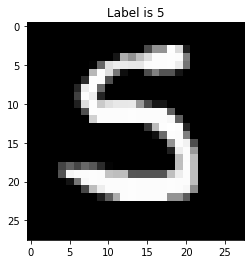

In [15]:
index  = 49991
k = train_set_x[:,index]
k = k.reshape((28, 28))
plt.title('Label is {label}'.format(label= training_data[1][index]))
plt.imshow(k, cmap='gray')

### 3. Activation Functions
***

### sigmoid
It takes a cumulative input into the layer, the matrix __Z__. Upon application of `sigmoid` function, the output matrix **H** is calculated. Also, Z is stored as the variable `sigmoid_memory` since it will be later used in backpropagation.

In [16]:
def sigmoid(Z):

    # Z is numpy array of shape (n, m) where n is number of neurons in the layer and m is the number of samples
    # sigmoid_memory is stored as it is used later on in backpropagation

    H = 1 / (1 + np.exp(-Z))

    sigmoid_memory = Z

    return H, sigmoid_memory

In [17]:
# 4 neurons in a layer, 2 input data points
Z = np.arange(8).reshape(4, 2)
H, sigmoid_memory = sigmoid(Z)

# output of 1st input data points
print(H[:, 0])

# output of top neuron
print(H[0, :])

[0.5        0.88079708 0.98201379 0.99752738]
[0.5        0.73105858]


### relu
It takes the cumulative input to the layer, matrix **Z**. Upon application of the `relu` function, matrix __H__ which is the output matrix is calculated. Also, Z is stored as `relu_memory` which will be later used in backpropagation.

In [18]:
def relu(Z):
    # Z is numpy array of shape (n, m) where n is number of neurons in the layer and m is the number of samples
    # relu_memory is stored as it is used later on in backpropagation

    H = np.maximum(0, Z)

    assert (H.shape == Z.shape)

    relu_memory = Z
    return H, relu_memory

In [19]:
# 4 neurons in a layer, 2 input data points
Z = np.array([1, 3, -1, -4, -5, 7, 9, 18]).reshape(4, 2)

H, relu_memory = relu(Z)

# cumulative input to the layer
print("cumulative input (Z) : {}\n".format(relu_memory))

# output of relu activation function
print("output : {}".format(H))

cumulative input (Z) : [[ 1  3]
 [-1 -4]
 [-5  7]
 [ 9 18]]

output : [[ 1  3]
 [ 0  0]
 [ 0  7]
 [ 9 18]]


### softmax
It takes the cumulative input to the layer, matrix **Z**. Upon application of the `softmax` function, the output matrix __H__ is calculated. Also, Z is stored as `softmax_memory` which will be later used in backpropagation.

In [20]:
def softmax(Z):
    # Z is numpy array of shape (n, m) where n is number of neurons in the layer and m is the number of samples
    # softmax_memory is stored as it is used later on in backpropagation

    Z_exp = np.exp(Z)
    Z_sum = np.sum(Z_exp, axis=0, keepdims=True)

    H = Z_exp / Z_sum  #normalising step
    softmax_memory = Z

    return H, softmax_memory

In [21]:
# output layer is made of 10 neurons, testing with 3 input data points
Z = np.array(np.arange(30)).reshape(10,3)

H, softmax_memory = softmax(Z)

# cumulative input to the layer
print("cumulative input (Z) : {}\n".format(softmax_memory))

# output of softmax activation function
print("output : {}".format(H))

cumulative input (Z) : [[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]
 [21 22 23]
 [24 25 26]
 [27 28 29]]

output : [[1.78595259e-12 1.78595259e-12 1.78595259e-12]
 [3.58718166e-11 3.58718166e-11 3.58718166e-11]
 [7.20504697e-10 7.20504697e-10 7.20504697e-10]
 [1.44717237e-08 1.44717237e-08 1.44717237e-08]
 [2.90672341e-07 2.90672341e-07 2.90672341e-07]
 [5.83831003e-06 5.83831003e-06 5.83831003e-06]
 [1.17265592e-04 1.17265592e-04 1.17265592e-04]
 [2.35534237e-03 2.35534237e-03 2.35534237e-03]
 [4.73083162e-02 4.73083162e-02 4.73083162e-02]
 [9.50212932e-01 9.50212932e-01 9.50212932e-01]]


### 4. FeedForward
***

### initialize_parameters
Let's now create a function **`initialize_parameters`** which initializes the weights and biases of the various layers.

The inputs to this function is a list named `dimensions`. The length of the list is the number layers in the network + 1 (the plus one is for the input layer, rest are hidden + output). The first element of this list is the dimensionality or length of the input (784 for the MNIST dataset). The rest of the list contains the number of neurons in the corresponding (hidden and output) layers.

For example `dimensions = [784, 3, 7, 10]` specifies a network for the MNIST dataset with two hidden layers and a 10-dimensional softmax output.

In [22]:
def initialize_parameters(dimensions):

    # dimensions is a list containing the number of neuron in each layer in the network
    # It returns parameters which is a python dictionary containing the parameters "W1", "b1", ..., "WL", "bL":

    np.random.seed(2)
    parameters = {}
    L = len(dimensions)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(dimensions[l],
                                                   dimensions[l - 1]) * 0.1
        parameters['b' + str(l)] = np.zeros((dimensions[l], 1))

    return parameters

### layer_forward

The function **`layer_forward`** implements the forward propagation for a certain layer 'l'. 

It calculates the cumulative input into the layer **Z** and uses it to calculate the output of the layer __H__. It takes `H_prev`, `W`, `b` and `activation function` as inputs and stores the `linear_memory`, `activation_memory` in the variable `memory` which will be used later in backpropagation.

In [23]:
def layer_forward(H_prev, W, b, activation='relu'):

    # H_prev is of shape (number of neurons in previous layer, number of examples)
    # W is weights matrix of shape (number of neurons in current layer, number of neurons in previous layer)
    # b is bias vector of shape (number of neurons in current layer, 1) (always a column vector)
    # activation is the activation to be used for forward propagation : "softmax", "relu", "sigmoid"

    # H is the output of the activation function
    # memory is a dictionary containing "linear_memory" and "activation_memory"

    linear_memory = (H_prev, W, b)

    Z = np.dot(W, H_prev) + b

    if activation == "sigmoid":
        H, activation_memory = sigmoid(Z)

    elif activation == "softmax":
        H, activation_memory = softmax(Z)

    elif activation == "relu":
        H, activation_memory = relu(Z)

    memory = (linear_memory, activation_memory)

    return H, memory

### L_layer_forward

**`L_layer_forward`** performs one forward pass through the whole network for all the training samples (note that we are feeding all training examples in one single batch).

In [24]:
def L_layer_forward(X, parameters):

    # X is input data of shape (input size, number of examples)
    # parameters is output of initialize_parameters()
    
    # HL is the last layer's post-activation value
    # memories is the list of memory containing (for a relu activation, for example):
    # - every memory of relu forward (there are L-1 of them, indexed from 1 to L-1), 
    # - the memory of softmax forward (there is one, indexed L) 

    memories = []
    H = X
    L = len(parameters) // 2
    
    # Implement relu layer (L-1) times as the Lth layer is the softmax layer
    for l in range(1, L):
        H_prev = H
        
        H, memory = layer_forward(H_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        
        memories.append(memory)
    
    # Implement the final softmax layer
    # HL here is the final prediction P as specified in the lectures
    HL, memory = layer_forward(H, parameters['W' + str(L)], parameters['b' + str(L)], "softmax")
    
    memories.append(memory)

    # number of data points in the output should be same as those present in the input
    assert(HL.shape == (10, X.shape[1]))
            
    return HL, memories

### 5. Network Loss
***

### compute_loss
**`compute_loss`** calculates the cross-entropy loss of a single pass

In [25]:
def compute_loss(HL, Y):

    # HL is probability matrix of shape (10, number of examples)
    # Y is true "label" vector shape (10, number of examples)

    # loss is the cross-entropy loss

    m = Y.shape[1]

    loss = -np.divide(np.sum(np.multiply(Y, np.log(HL))), m)

    # To make sure that the loss's shape is what we expect (e.g. this turns [[17]] into 17).
    loss = np.squeeze(loss)

    return loss

### 6. Backpropagation
***

### sigmoid-backward

In [26]:
def sigmoid_backward(dH, sigmoid_memory):
    
    # Implement the backpropagation of a sigmoid function
    # dH is gradient of the sigmoid activated activation of shape same as H or Z in the same layer    
    # sigmoid_memory is the memory stored in the sigmoid(Z) calculation
    
    Z = sigmoid_memory
    
    H = 1/(1+np.exp(-Z))
    
    # dZ is the gradient of the loss function with respect to cumulative input Z to a layer 'l'
    # dZ is calculated as Hadamard product of cumulative input 'Z' and differential of activation function
    # in the below formula, (H * (1 - H) ) represents the differential of 'sigmoid' activation function
    dZ = dH * H * (1-H)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

### relu-backward

In [27]:
def relu_backward(dH, relu_memory):
    
    # Implement the backpropagation of a relu function
    # dH is gradient of the relu activated activation of shape same as H or Z in the same layer    
    # relu_memory is the memory stored in the sigmoid(Z) calculation
    
    Z = relu_memory
    
    dZ = np.array(dH, copy=True)
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

### layer_backward

**`layer_backward`** is a complimentary function of **`layer_forward`**. Like `layer_forward`, `layer_backward` uses **dH** to calculate **dW**, **dH_prev** and **db**.

In [28]:
def layer_backward(dH, memory, activation='relu'):

    # takes dH and the memory calculated in layer_forward and activation as input to calculate the dH_prev, dW, db
    # performs the backpropagation depending upon the activation function

    linear_memory, activation_memory = memory
    H_prev, W, b = linear_memory
    
    # number of data points present in the input batch
    m = H_prev.shape[1]
    
    # generated gradient of weight, dW, is a tensor. That of bias, db, is a matrix
    #
    # hence both must be divided by the number of input data points to squish 
    # those into a matrix and vector respectively
    # 
    # this will ensure that shape of a gradient is same as corresponding weight and bias matrix
    # for parameter updates
    if activation == "relu":
        dZ = relu_backward(dH, activation_memory)
        
        dW = np.divide(np.dot(dZ, H_prev.T), m)
        db = np.divide(np.sum(dZ, axis=1, keepdims=True), m)
        
        dH_prev = np.dot(W.T, dZ)

    elif activation == "sigmoid":
        dZ = sigmoid_backward(dH, activation_memory)

        dW = np.divide(np.dot(dZ, H_prev.T), m)
        db = np.divide(np.sum(dZ, axis=1, keepdims=True), m)
        
        dH_prev = np.dot(W.T, dZ)

    return dH_prev, dW, db

### L_layer_backward

**`L_layer_backward`** performs backpropagation for the whole network. Recall that the backpropagation for the last layer, i.e. the softmax layer, is different from the rest, hence it is outside the reversed `for` loop.

In [29]:
def L_layer_backward(HL, Y, memories):
    
    # Following are the inputs:
    #       predicted value HL
    #       true target value Y
    #       memories calculated by L_layer_forward
    
    # returns the gradients calulated for all the layers as a dict

    gradients = {}
    
    # number of layers in the network
    L = len(memories)
    
    # number of data points
    m = HL.shape[1]
    
    # ensure shape of ground truth is same as calculated output
    Y = Y.reshape(HL.shape)
    
    # Perform backprop of output softmax layer
    current_memory = memories[-1]
    linear_memory, activation_memory = current_memory
    dZ = HL - Y
    H_prev, W, b = linear_memory
    
    gradients["dH" + str(L-1)] = np.dot(W.T, dZ)
    gradients["dW" + str(L)] = np.divide(np.dot(dZ, H_prev.T), m)
    gradients["db" + str(L)] = np.divide(np.sum(dZ, axis=1, keepdims=True), m)
    
    # Perform the backpropagation l-1 times
    for l in reversed(range(L-1)):
        
        current_memory = memories[l]
        
        dH_prev_temp, dW_temp, db_temp = layer_backward(gradients["dH" + str(l+1)], current_memory, 'relu')
        gradients["dH" + str(l)] = dH_prev_temp
        gradients["dW" + str(l + 1)] = dW_temp
        gradients["db" + str(l + 1)] = db_temp

    return gradients

### 7. Parameter Updates
***

In [30]:
def update_parameters(parameters, gradients, learning_rate):

    # parameters is a dictionary containing the parameters W and b for all the layers
    # gradients is a dictionary containing the gradient outputs of L_model_backward

    # returns updated weights after applying the gradient descent update

    L = len(parameters) // 2  # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l + 1)] = np.subtract(
            parameters["W" + str(l + 1)],
            np.multiply(learning_rate, gradients["dW" + str(l + 1)]))
        
        parameters["b" + str(l + 1)] = np.subtract(
            parameters["b" + str(l + 1)],
            np.multiply(learning_rate, gradients["db" + str(l + 1)]))

    return parameters

Having defined the bits and pieces of the feedforward and the backpropagation, let's now combine all that to form a model. The list `dimensions` has the number of neurons in each layer specified in it. For a neural network with 1 hidden layer with 45 neurons, you would specify the dimensions as follows:

In [31]:
dimensions = [784, 45, 10] #  three-layer model

### 8. Model
***

### L_layer_model
a composite function which takes the following input paramters:

  - training data as input **X**
  - ground truth label **Y**
  - **dimensions** as stated above
  - **learning_rate**
  - the number of iterations **num_iterations**
  - if you want to print the loss, **print_loss**

In [32]:
def L_layer_model(X, Y, dimensions, learning_rate = 0.0075, num_iterations = 3000, print_loss=False):
    
    np.random.seed(2)
    losses = []
    
    # Parameters initialization
    parameters = initialize_parameters(dimensions)
    
    for i in range(0, num_iterations):

        # Forward propagation
        HL, memories = L_layer_forward(X, parameters)
        
        # Compute loss
        loss = compute_loss(HL, Y)
    
        # Backward propagation
        gradients = L_layer_backward(HL, Y, memories)
        
        # Update parameters.
        parameters = update_parameters(parameters, gradients, learning_rate)
                
        # Printing the loss every 200 iterations
        if print_loss and i % 200 == 0:
            print ("Loss after iteration %i: %f" %(i, loss))
            losses.append(loss)
            
    # plotting the loss
    plt.plot(np.squeeze(losses))
    plt.ylabel('loss')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Since, it'll take a lot of time to train the model on 50,000 data points, we take a subset of 10,000 images

In [33]:
train_set_x_new = train_set_x[:,0:10000]
train_set_y_new = train_set_y[:,0:10000]
train_set_x_new.shape

(784, 10000)

### 9. Training
***

Loss after iteration 0: 2.420266
Loss after iteration 200: 1.874997
Loss after iteration 400: 1.355493
Loss after iteration 600: 1.000101
Loss after iteration 800: 0.802721
Loss after iteration 1000: 0.686624
Loss after iteration 1200: 0.611321
Loss after iteration 1400: 0.558733
Loss after iteration 1600: 0.519849
Loss after iteration 1800: 0.489858
Loss after iteration 2000: 0.465936
Loss after iteration 2200: 0.446298
Loss after iteration 2400: 0.429824
Loss after iteration 2600: 0.415757
Loss after iteration 2800: 0.403538


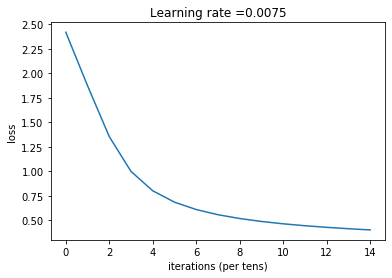

Time taken to complete training : 774.2483738999999


In [34]:
import timeit

start = timeit.default_timer()

parameters = L_layer_model(train_set_x_new, train_set_y_new, dimensions, num_iterations = 3000, print_loss = True)

stop = timeit.default_timer()

print("Time taken to complete training : {}".format(stop - start))